In [2]:
import numpy as np
import pandas as pd 

# Visualisation
import matplotlib.pyplot as plt

from datetime import datetime

# Scaling
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import r2_score,mean_squared_error

## Importing data into dataframe

In [3]:
df=pd.read_csv('archive-nifty/SBIN.csv',date_parser=True)
df.shape

(5163, 15)

In [4]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,SBIN,EQ,225.60,236.00,243.65,234.25,243.65,243.65,240.83,2373228,5.715338e+13,NaN,NaN,NaN
1,2000-01-04,SBIN,EQ,243.65,243.65,262.00,238.85,258.00,259.10,251.46,4495741,1.130506e+14,NaN,NaN,NaN
2,2000-01-05,SBIN,EQ,259.10,249.00,264.70,245.00,249.05,248.45,252.35,3434058,8.666008e+13,NaN,NaN,NaN
3,2000-01-06,SBIN,EQ,248.45,252.00,268.00,252.00,260.50,261.00,262.18,6658801,1.745817e+14,NaN,NaN,NaN
4,2000-01-07,SBIN,EQ,261.00,261.50,279.90,255.00,279.00,273.30,269.02,7873985,2.118287e+14,NaN,NaN,NaN


## Calculating momentum and storing it into dataframe

In [5]:
df["Momentum"] = df["Close"] - df["Open"]
df["MomentumValue"] = abs(df["Momentum"])

## Function to calculate the limits for the fuzzy membership

In [20]:
def getLimits(values):
    maximum = values.max()
    minimum = values.min()
    a = (0.15 * (maximum-minimum)) + minimum
    b = (0.30 * (maximum-minimum)) + minimum
    c = (0.45 * (maximum-minimum)) + minimum
    d = (0.55 * (maximum-minimum)) + minimum
    e = (0.70 * (maximum-minimum)) + minimum
    f = (0.85 * (maximum-minimum)) + minimum
    return (a,b,c,d,e,f)

## Class with methods to get the membership values

In [7]:
class Membership:
    
    def __init__(self, x, limits):
        
        (a,b,c,d,e) = limits
        self.vbr = self.getVBR(x, a, b)
        self.br = self.getBR(x, a, b, c)
        self.n = self.getN(x, b, c, d)
        self.bl = self.getBL(x, c, d, e)
        self.vbl = self.getVBL(x, d, e)
    
    def getVBR(self, x, a, b):
        
        if x <= a: return 1
        elif a <= x <=b: return (b-x)/(b-a)
        elif x >= b: return 0
        
    def getBR(self, x, a, b, c):
        
        if x <= a: return 0
        elif a <= x <= b: return (x-a)/(b-a)
        elif b <= x <= c: return (c-x)/(c-b)
        elif x >= c: return 0
        
    def getN(self, x, b, c, d):
        
        if x <= b: return 0
        elif b <= x <= c: return (x-b)/(c-b)
        elif c <= x <= d: return (d-x)/(d-c)
        elif x >= d: return 0
        
    def getBL(self, x, c, d, e):
        
        if x <= c: return 0
        elif c <= x <= d: return (x-c)/(d-c)
        elif d <= x <= e: return (e-x)/(e-d)
        elif x >= e: return 0
        
    def getVBL(self, x, d, e):
        
        if x >= e: return 1
        elif d <= x <= e: return (x-d)/(e-d)
        elif x <= d: return 0
        
    def getMembership(self):
        
        return (self.vbr, self.br, self.n, self.bl, self.vbl)
    

## Function to calculate the fuzzy membership

In [8]:
def getFuzzyMomentum(momentum, membership):
#     if momentum >= 0: return max(membership)
#     else: return sorted(set(membership))[-2]
    return max(membership)

## Function to estimate with fuzzy membership

In [9]:
def edtimatedFuzzyMomentum(fuzzyMomentums):
    estimatedValue = sum(fuzzyMomentums)/len(fuzzyMomentums)
    if 0 <= estimatedValue <= 0.42: label = "Bearish"
    elif 0.42 < estimatedValue <= 0.6: label = "Neutral"
    elif 0.6 < estimatedValue <= 1: label = "Bullish"
    return (estimatedValue, label)

## Getting the limits of the fuzzy function

In [21]:
limits = getLimits(df["Momentum"])

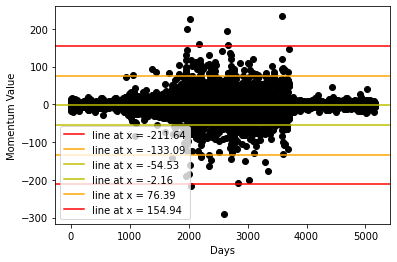

In [23]:
colors = ['r','orange','y','y','orange','red']
plt.scatter(df.index,df["Momentum"],color="k")
for xc,c in zip(limits,colors):
    plt.axhline(y=xc, label='line at x = {}'.format(round(xc,2)),c=c)
plt.xlabel("Days")
plt.ylabel("Momentum Value")
plt.legend()
plt.show()

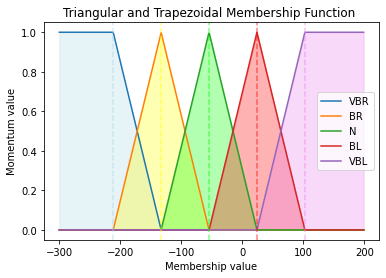

In [15]:
temp = []
for value in [i for i in range(-300,200)]:
    temp.append(Membership(value,limits).getMembership())
temp = pd.DataFrame(temp,columns=["VBR","BR","N","BL","VBL"])
temp["Momentum"] = [i for i in range(-300,200)]
temp.plot(x = "Momentum")
colors = ['lightblue','yellow','lime','red','violet']
for i in range(5):
    plt.fill_between(temp["Momentum"],temp.iloc[:,i],color = colors[i],alpha=0.3)
for xc,c in zip(limits,colors):
    plt.axvline(x=xc, label='line at x = {}'.format(round(xc,2)),ls="--",c=c,alpha=0.5)
plt.title("Triangular and Trapezoidal Membership Function ")
plt.xlabel("Membership value")
plt.ylabel("Momentum value")
plt.show()

In [12]:
memberships = []
for value in df["MomentumValue"].values:
    memberships.append(Membership(value,limits).getMembership())

In [13]:
fuzzyMomentums = []
for (momentum,membership) in zip(df["Momentum"].values,memberships):
    fuzzyMomentums.append(getFuzzyMomentum(momentum,membership))

In [14]:
memdf = pd.DataFrame(memberships,columns=["VBR","BR","N","BL","VBL"])
memdf["FuzzyMomentum"] = fuzzyMomentums

In [15]:
FuzzyDF = pd.merge(df[["Date","Open","Close","Momentum","MomentumValue"]],memdf,left_index=True,right_index=True)

In [16]:
FuzzyDF

,Date,Open,Close,Momentum,MomentumValue,VBR,BR,N,BL,VBL,FuzzyMomentum
0,2000-01-03,236.00,243.65,7.65,7.65,1.0,0.0,0.0,0.0,0.0,1.0
1,2000-01-04,243.65,259.10,15.45,15.45,1.0,0.0,0.0,0.0,0.0,1.0
2,2000-01-05,249.00,248.45,-0.55,0.55,1.0,0.0,0.0,0.0,0.0,1.0
3,2000-01-06,252.00,261.00,9.00,9.00,1.0,0.0,0.0,0.0,0.0,1.0
4,2000-01-07,261.50,273.30,11.80,11.80,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5158,2020-09-24,181.10,176.35,-4.75,4.75,1.0,0.0,0.0,0.0,0.0,1.0
5159,2020-09-25,179.00,182.20,3.20,3.20,1.0,0.0,0.0,0.0,0.0,1.0
5160,2020-09-28,184.00,187.25,3.25,3.25,1.0,0.0,0.0,0.0,0.0,1.0
5161,2020-09-29,188.50,185.05,-3.45,3.45,1.0,0.0,0.0,0.0,0.0,1.0


In [17]:
window = 14
Batches = []
for i in range(window,FuzzyDF.shape[0]):
    Batches.append(FuzzyDF.iloc[i-window:i,-1].values)
    
Batches = np.array(Batches)

In [18]:
estimated = []
for fuzzyMomentums in Batches:
    estimated.append(edtimatedFuzzyMomentum(fuzzyMomentums))

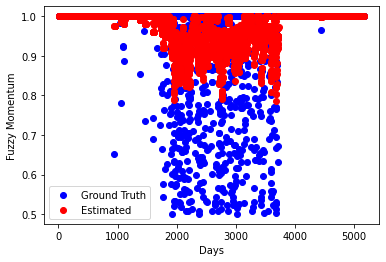

In [19]:
plt.scatter(FuzzyDF.index.values[14:],FuzzyDF["FuzzyMomentum"].values[14:],color="blue",label="Ground Truth")
plt.scatter(FuzzyDF.index.values[14:],[x for (x,y) in estimated],color="r",label="Estimated")
plt.xlabel("Days")
plt.ylabel("Fuzzy Momentum")
plt.legend()
plt.show()

In [20]:
mean_squared_error(FuzzyDF["FuzzyMomentum"].values[14:],[x for (x,y) in estimated])

0.0066585972638831415